In [1]:
from collections import defaultdict
from dataclasses import dataclass
import os
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

@dataclass
class EEGData:
    eegs: dict[str, pl.DataFrame]
    spects: dict[str, pl.DataFrame]

    def get_eeg(id):
        return self.eeg[id]

    def get_spect(id):
        return self.spects[id]

def build_eegfiles(eegs_ids, spectra_ids, eegs_path, spectra_path, use_tqdm=True):
    if use_tqdm:
        eegs_ids = tqdm(eegs_ids)
        spectra_ids = tqdm(spectra_ids)
    
    eegs_dict = {}
    for _id in eegs_ids:
        if not isinstance(_id, int):
            continue
        eegs_dict[_id] = pl.read_parquet(os.path.join(eegs_path, str(_id)+".parquet"))

    spectra_dict = {}
    for _id in spectra_ids:
        if not isinstance(_id, int):
            continue
        spectra_dict[_id] = pl.read_parquet(os.path.join(spectra_path, str(_id)+".parquet"))
    return EEGData(eegs_dict, spectra_dict)

def build_features(rowix, df, eeg_files, print_missing=False, ):
    # EEG features
    t_offset = df[rowix, "eeg_label_offset_seconds"]
    t0 = t_offset+20
    tf = t_offset+30
    pq_eeg  = eeg_files.eegs[df[rowix, 'eeg_id']]
    row_eeg = pq_eeg.with_columns(pl.Series(np.linspace(0,pq_eeg.shape[0]/200, num=pq_eeg.shape[0], endpoint=False)).alias('t'))
    return {
        "t_inner":row_eeg.filter((pl.col("t") >= t0) & (pl.col("t") < tf)),
        "t_full":row_eeg.filter((pl.col("t") >= t_offset) & (pl.col("t") < (t_offset+50)))
    }
    # eeg_features = pl.DataFrame({cn+"_avg":filt_row_eeg[cn].mean() for cn in pq_eeg.columns})

def load_eegs(df):
    eeg_files = build_eegfiles(
        df['eeg_id'].unique(),
        [],
        "data/train_eegs",
        "data/train_spectrograms",
    )
    eegs = [build_features(rowix, df, eeg_files) for rowix in range(df.shape[0])]
    return eegs


Bad key keymap.all_axes in file /Users/jhaberstroh/.matplotlib/matplotlibrc, line 15 ('keymap.all_axes : a # enable all axes')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.1/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
N=100
df_core = pl.read_csv("data/train.csv")
df_dev = df_core.join(df_core.select("spectrogram_id").unique().sample(N), on="spectrogram_id", how="inner")
eegs = load_eegs(df_dev)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 571.99it/s]
0it [00:00, ?it/s]


In [3]:
print(df_dev.shape)
df_eeg = pl.DataFrame(eegs)
print(df_eeg['t_inner'][0])

(837, 15)
shape: (2_000, 21)
┌────────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬────────┬────────┐
│ Fp1        ┆ F3         ┆ C3         ┆ P3        ┆ … ┆ T6        ┆ O2        ┆ EKG    ┆ t      │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---    ┆ ---    │
│ f32        ┆ f32        ┆ f32        ┆ f32       ┆   ┆ f32       ┆ f32       ┆ f32    ┆ f64    │
╞════════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪════════╪════════╡
│ -34.0      ┆ -13.07     ┆ -29.77     ┆ -4.85     ┆ … ┆ -12.48    ┆ 6.23      ┆ -21.18 ┆ 20.0   │
│ -37.720001 ┆ -19.620001 ┆ -37.189999 ┆ -8.06     ┆ … ┆ -9.24     ┆ 9.71      ┆ -19.25 ┆ 20.005 │
│ -29.23     ┆ -4.45      ┆ -32.150002 ┆ -5.27     ┆ … ┆ -10.13    ┆ 13.6      ┆ -13.87 ┆ 20.01  │
│ -34.889999 ┆ -11.16     ┆ -31.290001 ┆ -5.61     ┆ … ┆ -2.97     ┆ 13.52     ┆ -8.04  ┆ 20.015 │
│ -33.02     ┆ -10.24     ┆ -35.830002 ┆ -7.45     ┆ … ┆ 0.46      ┆ 16.219999 ┆

In [24]:


n_t = df_eeg['t_inner'][0].shape[0]

@tfd.JointDistributionCoroutine
def ar1():
    sigma = yield Root(tfd.HalfNormal(1.))
    rho = yield Root(tfd.Uniform(-1., 1.))
    x0 = yield tfd.Normal(0., sigma)

    def ar1_fun(x):
        # We apply the backshift operation here
        x_tm1 = tf.concat(
            [
                tf.zeros_like(
                    x[..., :1]
                ),
                x[..., :-1]
            ], 
            axis=-1
        )
        loc = x_tm1 * rho[..., None]
        return tfd.Independent(tfd.Normal(loc=loc, scale=sigma[..., None]),
                               reinterpreted_batch_ndims=1)
    dist = yield tfd.Autoregressive(
        distribution_fn=ar1_fun,
        sample0=tf.zeros([n_t], dtype=rho.dtype),
        num_steps = n_t,
        name="observed",
    )

prior_sample = ar1.sample(100)

In [28]:
import arviz as az
idata = az.from_dict(
    posterior={
        # TFP mcmc returns (num_samples, num_chains, ...), we swap
        # the first and second axis below for each RV so the shape
        # is what ArviZ expects.
        ix:np.swapaxes(prior_sample[ix][:,np.newaxis], 1, 0) for ix, v in enumerate(prior_sample)
    },
 )
idata

Inference data with groups:
	> posterior

In [37]:
run_mcmc = tf.function(
    tfp.experimental.mcmc.windowed_adaptive_nuts,
    autograph=False,
    jit_compile=True
)
mcmc_samples, sampler_stats = run_mcmc(
    1000, 
    ar1,
    n_chains=4,
    num_adaptation_steps=1000,
    observed=df_eeg['t_inner'][0].cast(pl.Float32)
)

ValueError: Dimensions must be equal, but are 2000 and 4 for '{{node mcmc_retry_init/batched_las_vegas_algorithm/JointDistributionCoroutine_CONSTRUCTED_AT_top_level/unnormalized_log_prob/observed/unnormalized_log_prob/mul}} = Mul[T=DT_FLOAT](mcmc_retry_init/batched_las_vegas_algorithm/JointDistributionCoroutine_CONSTRUCTED_AT_top_level/unnormalized_log_prob/observed/unnormalized_log_prob/concat, mcmc_retry_init/batched_las_vegas_algorithm/JointDistributionCoroutine_CONSTRUCTED_AT_top_level/unnormalized_log_prob/observed/unnormalized_log_prob/strided_slice_2)' with input shapes: [2000,21], [4,1].

In [ ]:
regression_idata = az.from_dict(
    posterior={
        # TFP mcmc returns (num_samples, num_chains, ...), we swap
        # the first and second axis below for each RV so the shape
        # is what ArviZ expects.
        k:np.swapaxes(v.numpy(), 1, 0)
        for k, v in mcmc_samples._asdict().items()
    },
    sample_stats={
        k:np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]
    }
)



<Axes: >

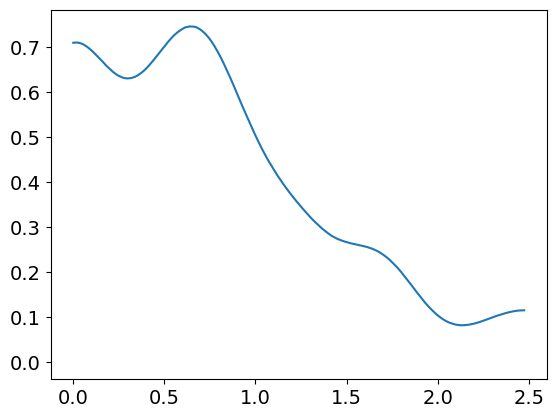

<Axes: >

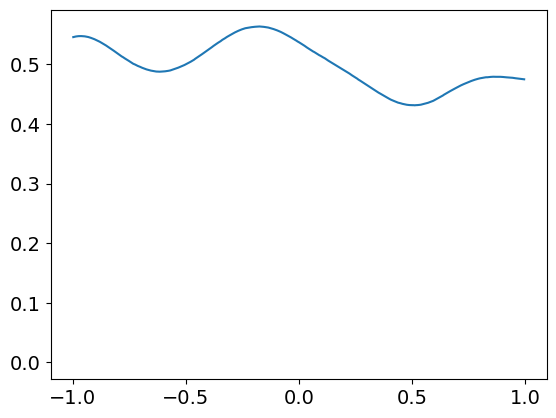

In [21]:
az.plot_(idata.posterior[1])